# Imports

In [14]:
import os
import sys
import importlib
import json
import uuid

import numpy as np
import pandas as pd
import scipy.ndimage as snd
import skimage
import cv2
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import plotly


# !py -m pip install numpy
# !py -m pip install pandas
# !py -m pip install scipy
# !py -m pip install opencv-python
# !py -m pip install matplotlib
# !py -m pip install plotly

if os.getcwd().split("/")[-1] == "notebooks":  # if cwd is located where this file is
    os.chdir("../..")  # go two folders upward (the if statement prevents error if cell is rerun)
directory_path = os.path.abspath(os.path.join("src"))
if directory_path not in sys.path:
    sys.path.append(directory_path)
print(directory_path)

import EyeTraumaAnalysis

/Users/ryerrabelli/Library/CloudStorage/GoogleDrive-ryerrabelli@gmail.com/My Drive/Computer Backups/Rahul Yerrabelli drive/PythonProjects/EyeTraumaAnalysis/src


In [ ]:
importlib.reload(EyeTraumaAnalysis);

# Helper and testing functions

In [7]:
def get_spatial_metrics(mask):
    # scipy can perform the mean (center of mass), but not the standard deviation
    # spatial_means = snd.center_of_mass(mask)
    x = np.linspace(0, 1, mask.shape[1])
    y = np.linspace(0, 1, mask.shape[0])
    xgrid, ygrid = np.meshgrid(x, y)
    grids = {"x": xgrid, "y":ygrid}
    to_return = {"x":{}, "y":{}}
    for ind, grid in grids.items():
        to_return[ind]["mean"] = np.mean(grids[ind], where=mask.astype(bool))
        to_return[ind]["sd"] = np.std(grids[ind], where=mask.astype(bool))
    return to_return


In [10]:
### Per Cluster Masking ### <-- for individual image use
def draw_cluster_masking(img, K=10):
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            #target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
            target1 = img.copy()
            target1[kmeans_thresholds[ind].astype(bool)] = [127,255,127,255]
            axs.flat[ind].imshow(target1)
            spatial_metrics = get_spatial_metrics(kmeans_thresholds[ind])
            hsv_rank = centers_indices[ind]
            hsv_center = centers_sorted[ind]
            # Draw left title
            axs.flat[ind].set_title(
                "HSV \n"+
                f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                fontsize=8, loc="left"
            )
            # Draw right title
            axs.flat[ind].set_title(
                f"Location:" + "\n"+
                f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                fontsize=8, loc="right", fontfamily="monospace",
            )
            # axs.flat[ind].set_title(
            #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
            #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
        else:
            # remove axes for empty cells
            axs.flat[ind].axis("off")

In [11]:
def draw_separate_clusters(img, filename=None, labelled=True, K_val=10):
    img_bgr = image.img
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    Z_hsv = img_hsv.reshape((-1,3))
    # convert to np.float32
    Z_hsv = np.float32(Z_hsv)
    # calculate K-means segmentation
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,centers=cv2.kmeans(Z_hsv,K_val,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    centers = np.uint8(centers)
    res_hsv = centers[label.flatten()]
    res_hsv2 = res_hsv.reshape(img_hsv.shape)
    res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
    centers_sorted = centers[centers[:, 2].argsort()]
    kmeans_thresholds = []
    for ind in range(K_val):
        kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
    centers_indices = centers_sorted.argsort(axis=0)
    for i in range(K_val):
        # propogate variables
        target = img.copy()
        # target[kmeans_thresholds[i].astype(bool)] = [127,255,127,255]
        target[np.where(kmeans_thresholds[i])] = [127,255,127,255]
        spatial_metrics = get_spatial_metrics(kmeans_thresholds[i])
        hsv_rank, hsv_center = centers_indices[i], centers_sorted[i]
        # generate plot
        if labelled:
            plt.title(
                    "HSV \n"+
                    f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                    f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                    fontsize=8, loc="left"
                )
            plt.title(
                    f"Location:" + "\n"+
                    f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                    f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                    fontsize=8, loc="right", fontfamily="monospace",
                )
        plt.imshow(target)
        # save plot as PNG
        if filename is not None:
            if labelled:
                fpath = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/labelled/"
            else:
                fpath = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/non-labelled/"
            plt.savefig(f"{fpath}{filename}_v{i}.png", format="png")
        # plt.clf()

In [12]:
def reverse_clustered_image(image_path, K=10):
    # Load the image
    summed_image = plt.imread(image_path)

    # Split the image into its component masks
    masks = []
    for ind in range(K):
        mask = np.zeros(summed_image.shape[:2], dtype=np.uint8)
        mask[summed_image[:,:,0] == ind*25] = 255
        masks.append(mask)

    return masks

In [ ]:
np.unique(reverse_clustered_image("C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/all_clusters_indicated/000.png")[0])

#  Create clusters

In [ ]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/Ergonautus/Full Dataset/000.png")
K = 10
## Clustered View
img_bgr = image.img
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
Z_hsv = img_hsv.reshape((-1,3))
Z_hsv = np.float32(Z_hsv)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,centers=cv2.kmeans(Z_hsv,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
res_hsv = centers[label.flatten()]
res_hsv2 = res_hsv.reshape(img_hsv.shape)
res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
centers_sorted = centers[centers[:, 2].argsort()]
kmeans_thresholds = []
for ind in range(K):
    kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
# center indices
centers_indices = centers_sorted.argsort(axis=0)
##
summed_image = np.zeros(kmeans_thresholds[0].shape)
for ind in range(K):
    summed_image += int(ind * 25) * kmeans_thresholds[ind]

In [ ]:
summed_image

In [ ]:
draw_cluster_masking(image.img)

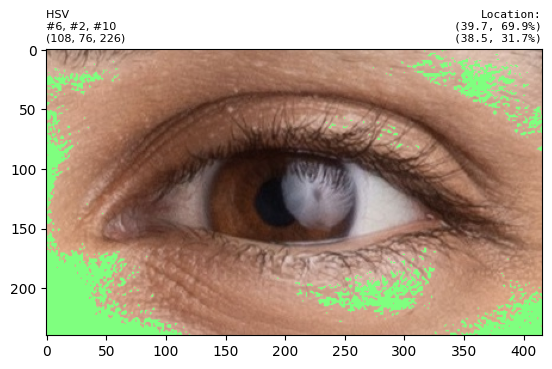

In [13]:
image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
draw_separate_clusters(image.img, filename=None)

In [ ]:
draw_separate_clusters(image.img, filename=None, labelled=False)

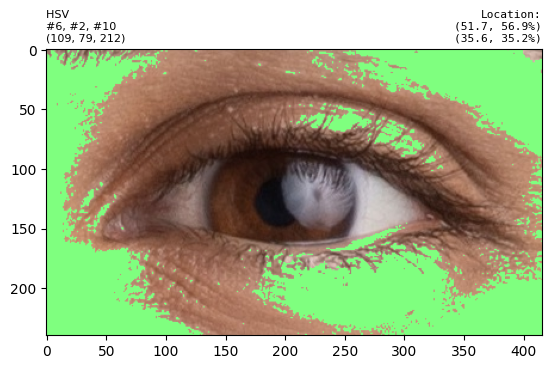

In [18]:
draw_separate_clusters(image.img,
                       labelled=True)

In [ ]:
# create all the labelled data
for sample in images:
    filepath = f"C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/01_raw/Ergonautus/Full Dataset/{sample}"
    name = sample.split(".")[0]
    image_obj = EyeTraumaAnalysis.Image(filepath)
    draw_separate_clusters(image_obj.img, filename=name, labelled=True, K_val=10)

In [ ]:
target1[kmeans_thresholds[ind].astype(bool)]

In [ ]:
image.img.shape

In [ ]:
kmeans_thresholds[0].dtype

In [ ]:
xgrid

In [ ]:
type(xgrid)

In [ ]:
type(image.img.copy())

In [ ]:
### Running Code on Several Images ###
from PIL import Image as PILimg

K = 10
# save_directory = "C:\\Users\\ethan\\PycharmProjects\\EyeTraumaAnalysis\\data\\kmeans_clustering_applied" # data/kmeans_clustering_applied; hard coded for PC
# NOTE: While this isn't a preferable implementation, the previous code, which was flexible per system, ran into PermissionError [Errno 13]

for image_sample in images:
    # image = EyeTraumaAnalysis.Image(f"data/01_raw/{image_sample}")
    image = EyeTraumaAnalysis.Image(f"data/01_raw/Ergonautus/Full Dataset/{image_sample}")

    ## Clustered View
    img_bgr = image.img
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    Z_hsv = img_hsv.reshape((-1,3))
    Z_hsv = np.float32(Z_hsv)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,centers=cv2.kmeans(Z_hsv,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    res_hsv = centers[label.flatten()]
    res_hsv2 = res_hsv.reshape(img_hsv.shape)
    res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
    centers_sorted = centers[centers[:, 2].argsort()]
    kmeans_thresholds = []
    for ind in range(K):
        kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
    # center indices
    centers_indices = centers_sorted.argsort(axis=0)
    ##
    summed_image = np.zeros(kmeans_thresholds[0].shape)
    for ind in range(K):
        summed_image += int(ind * 25) * kmeans_thresholds[ind] / 255
    plt.imsave(f"C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/all_clusters_indicated/{image_sample.split('.PNG')[0]}.png", summed_image)
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(summed_image, cmap="gray")
    im3=axs.flat[3].imshow(summed_image, cmap="terrain")
    plt.colorbar(im3,ax=axs.flat[3], shrink=0.8)
    save_directory = f"{directory_path}".replace("src", "data")
    # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\ergonautus-10k\\clustered_view\\{image_sample.split('.PNG')[0]}.png",
    #             format='png')

    ## Per Cluster Masking
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            #target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
            target1 = image.img.copy()
            target1[kmeans_thresholds[ind].astype(bool)] = [127,255,127,255]
            axs.flat[ind].imshow(target1)
            spatial_metrics = get_spatial_metrics(kmeans_thresholds[ind])
            hsv_rank = centers_indices[ind]
            hsv_center = centers_sorted[ind]
            # Draw left title
            axs.flat[ind].set_title(
                "HSV \n"+
                f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                fontsize=8, loc="left"
            )
            # Draw right title
            axs.flat[ind].set_title(
                f"Location:" + "\n"+
                f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                fontsize=8, loc="right", fontfamily="monospace",
            )
            # axs.flat[ind].set_title(
            #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
            #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
        else:
            # remove axes for empty cells
            axs.flat[ind].axis("off")
        # save axis as singular image
        if (ind < 10):
            extent = axs.flat[ind].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            # fig.savefig(f"C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/{image_sample.split('.PNG')[0]}_v{ind}.png", format="png", bbox_inches = extent.expanded(1.1, 1.2))
    save_dir = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data"
    # plt.savefig(f"{save_dir}\\kmeans_clustering_applied\\ergonautus-10k\\per_cluster_mask\\{image_sample.split('.PNG')[0]}.png", format='png')

    # row_ct = int(np.sqrt(K))
    # col_ct = int(np.ceil(K/row_ct))
    # fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    # for ind in range(row_ct*col_ct):
    #     if ind < K:
    #         target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
    #         axs.flat[ind].imshow(target1)
    #         axs.flat[ind].set_title(
    #         f"Mean: {round(snd.mean(target1), 3)}\nStd: {round(snd.standard_deviation(target1), 3)}"
    #     )
    #         # axs.flat[ind].set_title(
    #         #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
    #         #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
    #     else:
    #         # remove axes for empty cells
    #         axs.flat[ind].axis("off")
    # # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\K-{K}\\per_cluster_mask\\{image_sample.split('.jpg')[0]}.png", format='png')
    # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\ergonautus-10k\\per_cluster_mask\\{image_sample.split('.PNG')[0]}.png", format='png')

    # close to prevent overconsumption of memory
    plt.close()